In [58]:
import re
import string
import inflect
import pyLDAvis as pyldavis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures as bam, BigramCollocationFinder as bcf
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation as LDA

inflect_eng = inflect.engine()
lemmatizer = WordNetLemmatizer()
sns.set()

In [2]:
data_dir = Path('../../flav_data')

In [68]:
data = pd.DataFrame()
for file in data_dir.glob('*.txt'):
    frame = pd.read_csv(file, sep='\t', names=['chunk', 'start', 'stop', 'text'], header=None).dropna()
    frame['id'] = file.stem
    data = pd.concat([data, frame], axis=0)

In [14]:
len(data)

6501

In [69]:
# Make lowercase
data.text = data.text.apply(str.lower)

# Numbers to words
def number_to_words(line):
    def do_number_to_words(num):
        words = inflect_eng.number_to_words(num)
        words = words.replace(" and", "")
        words = words.replace('-', ' ')
        return words
    return re.sub("([0-9]+)", lambda x: do_number_to_words(x.group()), line)
data.text = data.text.apply(number_to_words)

# # Remove punctuation
data.text = data.text.str.replace('-', ' ')
data.text = data.text.str.replace(f'[{string.punctuation}]', '')

#Tokenize
data.text = data.text.apply(word_tokenize)

# Lemmatize
data.text = data.text.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

In [16]:
data.text.iloc[:6].apply(print);

hey there i m guy fieri and we re rolling out looking for america s greatest diner drive in and dive this trip get it on there we re kicking it into high gear while ridiculous and
out of control for a full throttle power of food truck hear that every day do nt you from serious seafood in vancouver that much shellfish stand out sandwich
in nashville this is gourmet right here man in san francisco a short rib with a japanese twist this is asian street food at it best
we re tackling taco in wife forgot where and half of that the bomb burger in key west that need to make it into my repertoire plus in southern california it is making it happen
real deal mexican this is really amazing and righteous chinese latin fusion it s killing you so hit the road and get in
line lady and gentleman you are stepping into the ridiculous zone for some of the best meal on four wheel take me to flavortown that s all right


In [38]:
cv = TfidfVectorizer(stop_words='english')
X = cv.fit_transform(data.text.tolist())

In [39]:
lda = LDA(n_components=10)
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [42]:
ldavis = pyldavis.sklearn.prepare(lda, X, cv)
pyldavis.save_html(ldavis, 'ldavis.html')

In [71]:
a = bcf.from_documents(data.text)

In [72]:
b = bam()

In [73]:
q = dict(a.score_ngrams(b.raw_freq))

In [75]:
q['onion', 'garlic']

1.1776205000176643e-05

In [23]:
X_sum = X.sum(axis=0).A.squeeze()
labels = cv.get_feature_names()

In [24]:
[labels[i] for i in X_sum.argsort()[:50]]

['essentially',
 'tambourine',
 'sotfour',
 'dudas',
 'bollito',
 'mott',
 'boomerang',
 'beantown',
 'muslim',
 'electricity',
 'stogy',
 'stokie',
 'whack',
 'tighter',
 'bend',
 'gardener',
 'bully',
 'giddyap',
 'bureau',
 'limpia',
 'shaking',
 'tarentines',
 'relative',
 'carrying',
 'randy',
 'rita',
 'loo',
 'pomp',
 'romana',
 'coop',
 'purveyor',
 'ciao',
 'broccolini',
 'baseball',
 'fk',
 'initially',
 'retain',
 'simpler',
 'introduced',
 'chacha',
 'fella',
 'diwali',
 'corporate',
 'vet',
 'joining',
 'cinema',
 'aaron',
 'renal',
 'narrow',
 'boiler']

In [25]:
inds = X_sum.argsort()[-1:-50:-1]

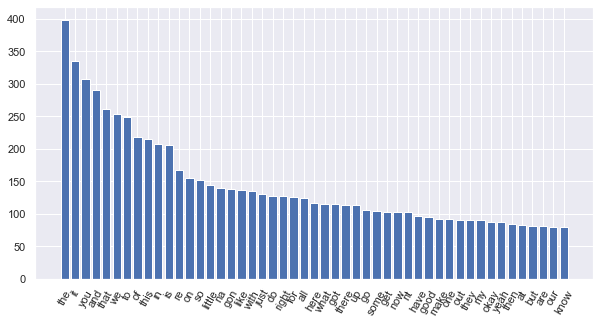

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar([labels[i] for i in inds], X_sum[inds])
_ = ax.set_xticklabels([labels[i] for i in inds], rotation=60)

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.A)

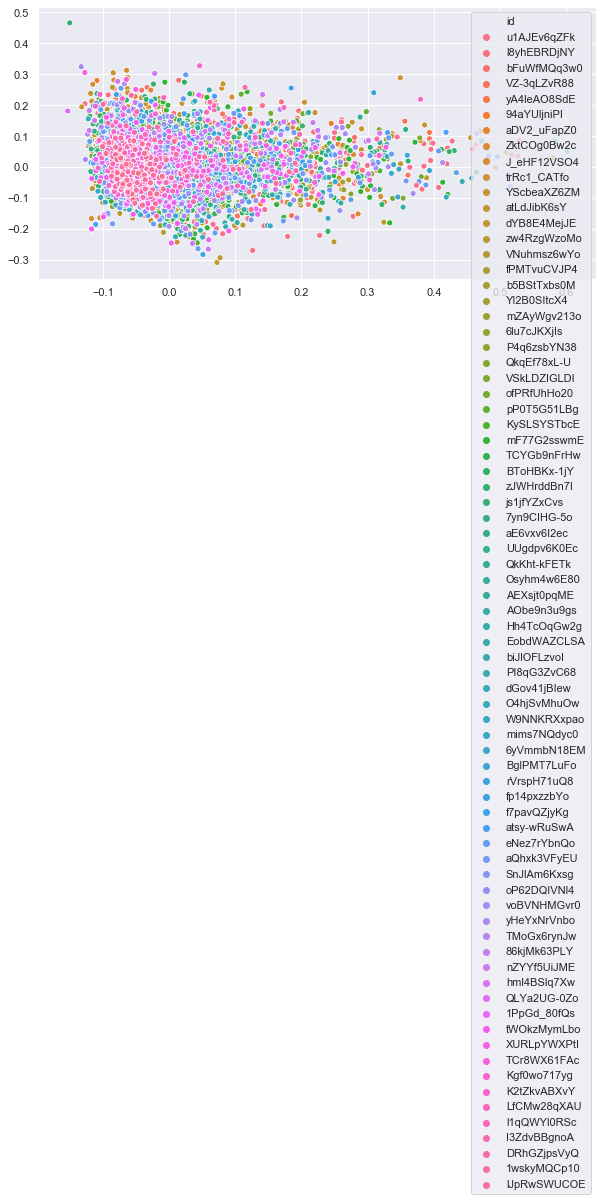

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(*X_pca.T, hue=data.id)

In [182]:
X

<3394x7469 sparse matrix of type '<class 'numpy.int64'>'
	with 93804 stored elements in Compressed Sparse Row format>